In [74]:
%load_ext autoreload
%autoreload 2

import os
# Run everything on CPU, if GPU is available comment out
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""


import sys
sys.path.append("src/")
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow import keras
from functools import partial
import pickle

from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    seq_contains_mdm2_motif,
    seq_contains_12ca5_motif,
)
from utils.utils import seed_everything
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import scipy.stats as stats


def draw_custom_pairplot(df):
    grd = sns.pairplot(
        df,
        kind="reg",
        corner=False,
        diag_kind="kde",
        plot_kws={
            "line_kws": {"color": "black"},
            "scatter_kws": {
                "alpha": 0.5,
            },
        },
    )

    def hide_plots(x, y, **kwargs):
        ax = plt.gca()
        ax.clear()
        ax.tick_params(
            axis="x",
            which="both",
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False,
        )
        ax.tick_params(
            axis="y",
            which="both",
            bottom=False,
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False,
        )
        ax.set_frame_on(True)

    num_comparisons = (len(df) ** 2) / 2

    def summary(x, y, **kwargs):
        correlation, pvalue = stats.pearsonr(x, y)
        corr_str = "%.3f" % round(correlation, 3)

        # Bonferroni correction
        corrected_pvalue = min(pvalue * num_comparisons, 1)
        pval_str = "%.3f" % round(corrected_pvalue, 3)
        label = f"corr: {corr_str}\np-val: {pval_str}"

        ax = plt.gca()
        ax.annotate(
            label,
            xy=(0.15, 0.4),
            size=20,
            xycoords=ax.transAxes,
            color="#440154",
        )

    sns.set(font_scale=2.5)

    grd = grd.map_upper(hide_plots)
    grd = grd.map_upper(summary)
    
    for ax in grd.axes.flatten():
        ax.set_xlabel(ax.get_xlabel(), rotation=30, fontsize=22)
        if ax.get_xlabel() == "width":
            ax.set_xlim(25, 270) 
        elif ax.get_xlabel() == "depth":
            ax.set_xlim(5.5, 10.5) 
        elif ax.get_xlabel() == "batch_size":
            ax.set_xlim(50, 300) 
        elif ax.get_xlabel() == "weight_decay":
            ax.set_xlim(0, 0.6) 
        elif ax.get_xlabel() == "learning_rate":
            ax.set_xlim(0, 0.1)
        elif ax.get_xlabel() == "num_epochs":
            ax.set_xlim(0, 21) 
        elif ax.get_xlabel() == "dropout":
            ax.set_xlim(0, 0.6) 
            
        ax.set_ylabel(
            ax.get_ylabel(),
            rotation=30,
            fontsize=22,
            labelpad=100,
            loc="bottom"
        )

    fig = plt.figure()
    fig.align_labels()
    plt.show()


In [76]:
protein_of_interest = '12ca5' #'MDM2' # "12ca5"#"MDM2" 
other_protein = 'MDM2' #"MDM2"#"12ca5"
top_k_size = 500 if protein_of_interest == "MDM2" else 1000
seq_check = (
    seq_contains_mdm2_motif
    if protein_of_interest == "MDM2"
    else seq_contains_12ca5_motif
)

In [77]:
import json
import os
import pandas as pd
import seaborn as sns

f = f"{protein_of_interest}_hyperparam_output_100_tpe.csv"
if os.path.exists(f):
    SAVE_DF = pd.read_csv(f)
else:
    SAVE_DF = pd.DataFrame(
        columns=[
            "width",
            "depth",
            "batch_size",
            "weight_decay",
            "learning_rate",
            "num_epochs",
            "dropout",
            "combined_auc",
            "loss",
        ]
    )
SAVE_DF

,width,depth,batch_size,weight_decay,learning_rate,num_epochs,dropout,combined_auc,loss
0,46.0,10.0,188.0,0.00716,0.00137,19.0,0.00202,0.798087,13.679427
1,167.0,8.0,252.0,0.00032,0.00490,16.0,0.00044,0.834454,13.854496
2,95.0,8.0,197.0,0.00024,0.00513,8.0,0.00034,0.846949,13.152051
3,101.0,7.0,90.0,0.00407,0.00014,3.0,0.00055,0.858583,12.215259
4,104.0,6.0,235.0,0.00013,0.01611,14.0,0.07145,0.801620,13.139280
...,...,...,...,...,...,...,...,...,...
95,37.0,10.0,255.0,0.00704,0.00612,8.0,0.02531,0.894174,13.048948
96,116.0,7.0,122.0,0.00029,0.05125,9.0,0.01565,0.410117,14.254991
97,72.0,6.0,247.0,0.02054,0.00486,11.0,0.01978,0.842123,13.220360
98,84.0,10.0,195.0,0.00054,0.01679,14.0,0.03076,0.848931,13.746470


In [78]:
deduped_df = SAVE_DF.drop_duplicates(subset=['width', 'depth', 'batch_size', 'weight_decay', 'learning_rate', 'num_epochs', 'dropout', 'loss'])
print(len(deduped_df))


100


In [79]:
from scipy import stats

# Filter outliers (especially important for loss)
deduped_df = deduped_df[(np.abs(stats.zscore(deduped_df)) < 3).all(axis=1)]
len(deduped_df)

91

In [80]:
deduped_df[deduped_df['combined_auc'] == deduped_df.max()['combined_auc']]

,width,depth,batch_size,weight_decay,learning_rate,num_epochs,dropout,combined_auc,loss
62,103.0,7.0,236.0,0.00118,0.00069,14.0,0.48128,0.920114,11.842179


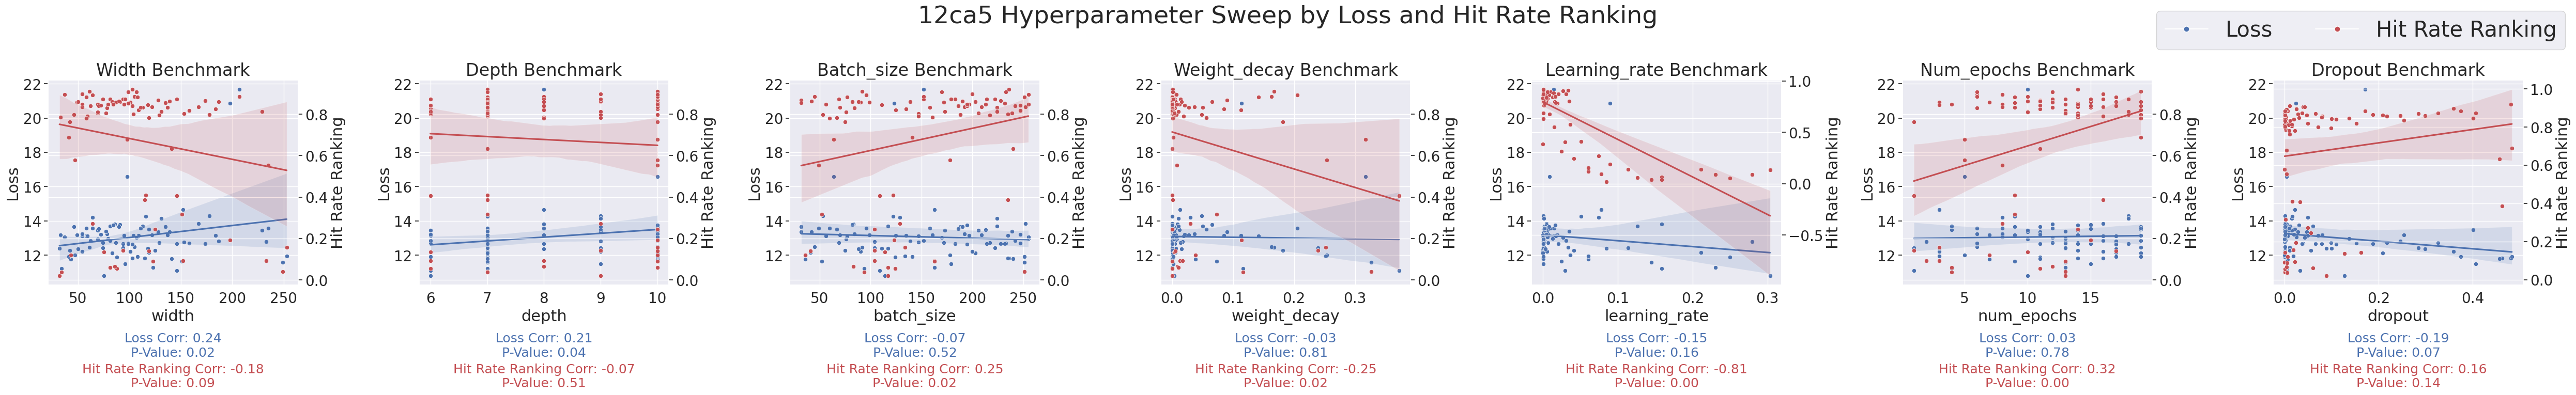

In [81]:
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

# List of columns to plot against (loss, combined_auc)
plot_cols = ['width', 'depth', 'batch_size', 'weight_decay', 'learning_rate', 'num_epochs', 'dropout']
sns.set(rc={'axes.labelsize': 22, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 'legend.fontsize': 22})

columns = 7
z_cutoff = 1
fig, axes = plt.subplots(ncols=columns, nrows=int(np.ceil(len(plot_cols) / columns)), figsize=(50, 10))
plt.subplots_adjust(wspace=0.5, hspace=3)  # Increase the vertical space between subplots

legend_elements = {
    'Loss': plt.Line2D([0], [0], marker='o', color='w', label='Loss', markerfacecolor='b', markersize=8),
    'Hit Rate Ranking': plt.Line2D([0], [0], marker='o', color='w', label='Hit Rate Ranking', markerfacecolor='r', markersize=8)
}

for i, ax in enumerate(axes.flatten()):
    if i >= len(plot_cols): 
        print('we skipping? ', i)
        continue
    col = plot_cols[i]

    ax = sns.scatterplot(data=deduped_df, x=col, y='loss', color='b', ax=ax)

    ax_combined_auc = ax.twinx()
    ax_combined_auc = sns.scatterplot(data=deduped_df, x=col, y='combined_auc', color='r', ax=ax_combined_auc)

    sns.regplot(data=deduped_df, x=col, y='loss', scatter=False, ci=99, color='b', ax=ax)
    sns.regplot(data=deduped_df, x=col, y='combined_auc', scatter=False, ci=99, color='r', ax=ax_combined_auc)

    ax.set_ylabel('Loss')
    ax_combined_auc.set_ylabel('Hit Rate Ranking')
    ax.set_title(f'{col.capitalize()} Benchmark', fontsize=24)

    corr_loss, pval_loss = pearsonr(deduped_df[col], deduped_df['loss'])
    corr_combined_auc, pval_combined_auc = pearsonr(deduped_df[col], deduped_df['combined_auc'])

    ax.annotate(f'Loss Corr: {corr_loss:.2f}\nP-Value: {pval_loss:.2f}',
                xy=(0.5, -0.35), xycoords='axes fraction', ha='center', fontsize=18, color='b')

    ax_combined_auc.annotate(f'Hit Rate Ranking Corr: {corr_combined_auc:.2f}\nP-Value: {pval_combined_auc:.2f}',
                             xy=(0.5, -0.50), xycoords='axes fraction', ha='center', fontsize=18, color='r')

fig.suptitle(f'{protein_of_interest} Hyperparameter Sweep by Loss and Hit Rate Ranking', fontsize=34)

# Create a separate legend outside the subplots and position it below them
fig.legend(handles=list(legend_elements.values()), labels=list(legend_elements.keys()), loc='upper right', fontsize=30, ncol=2)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()


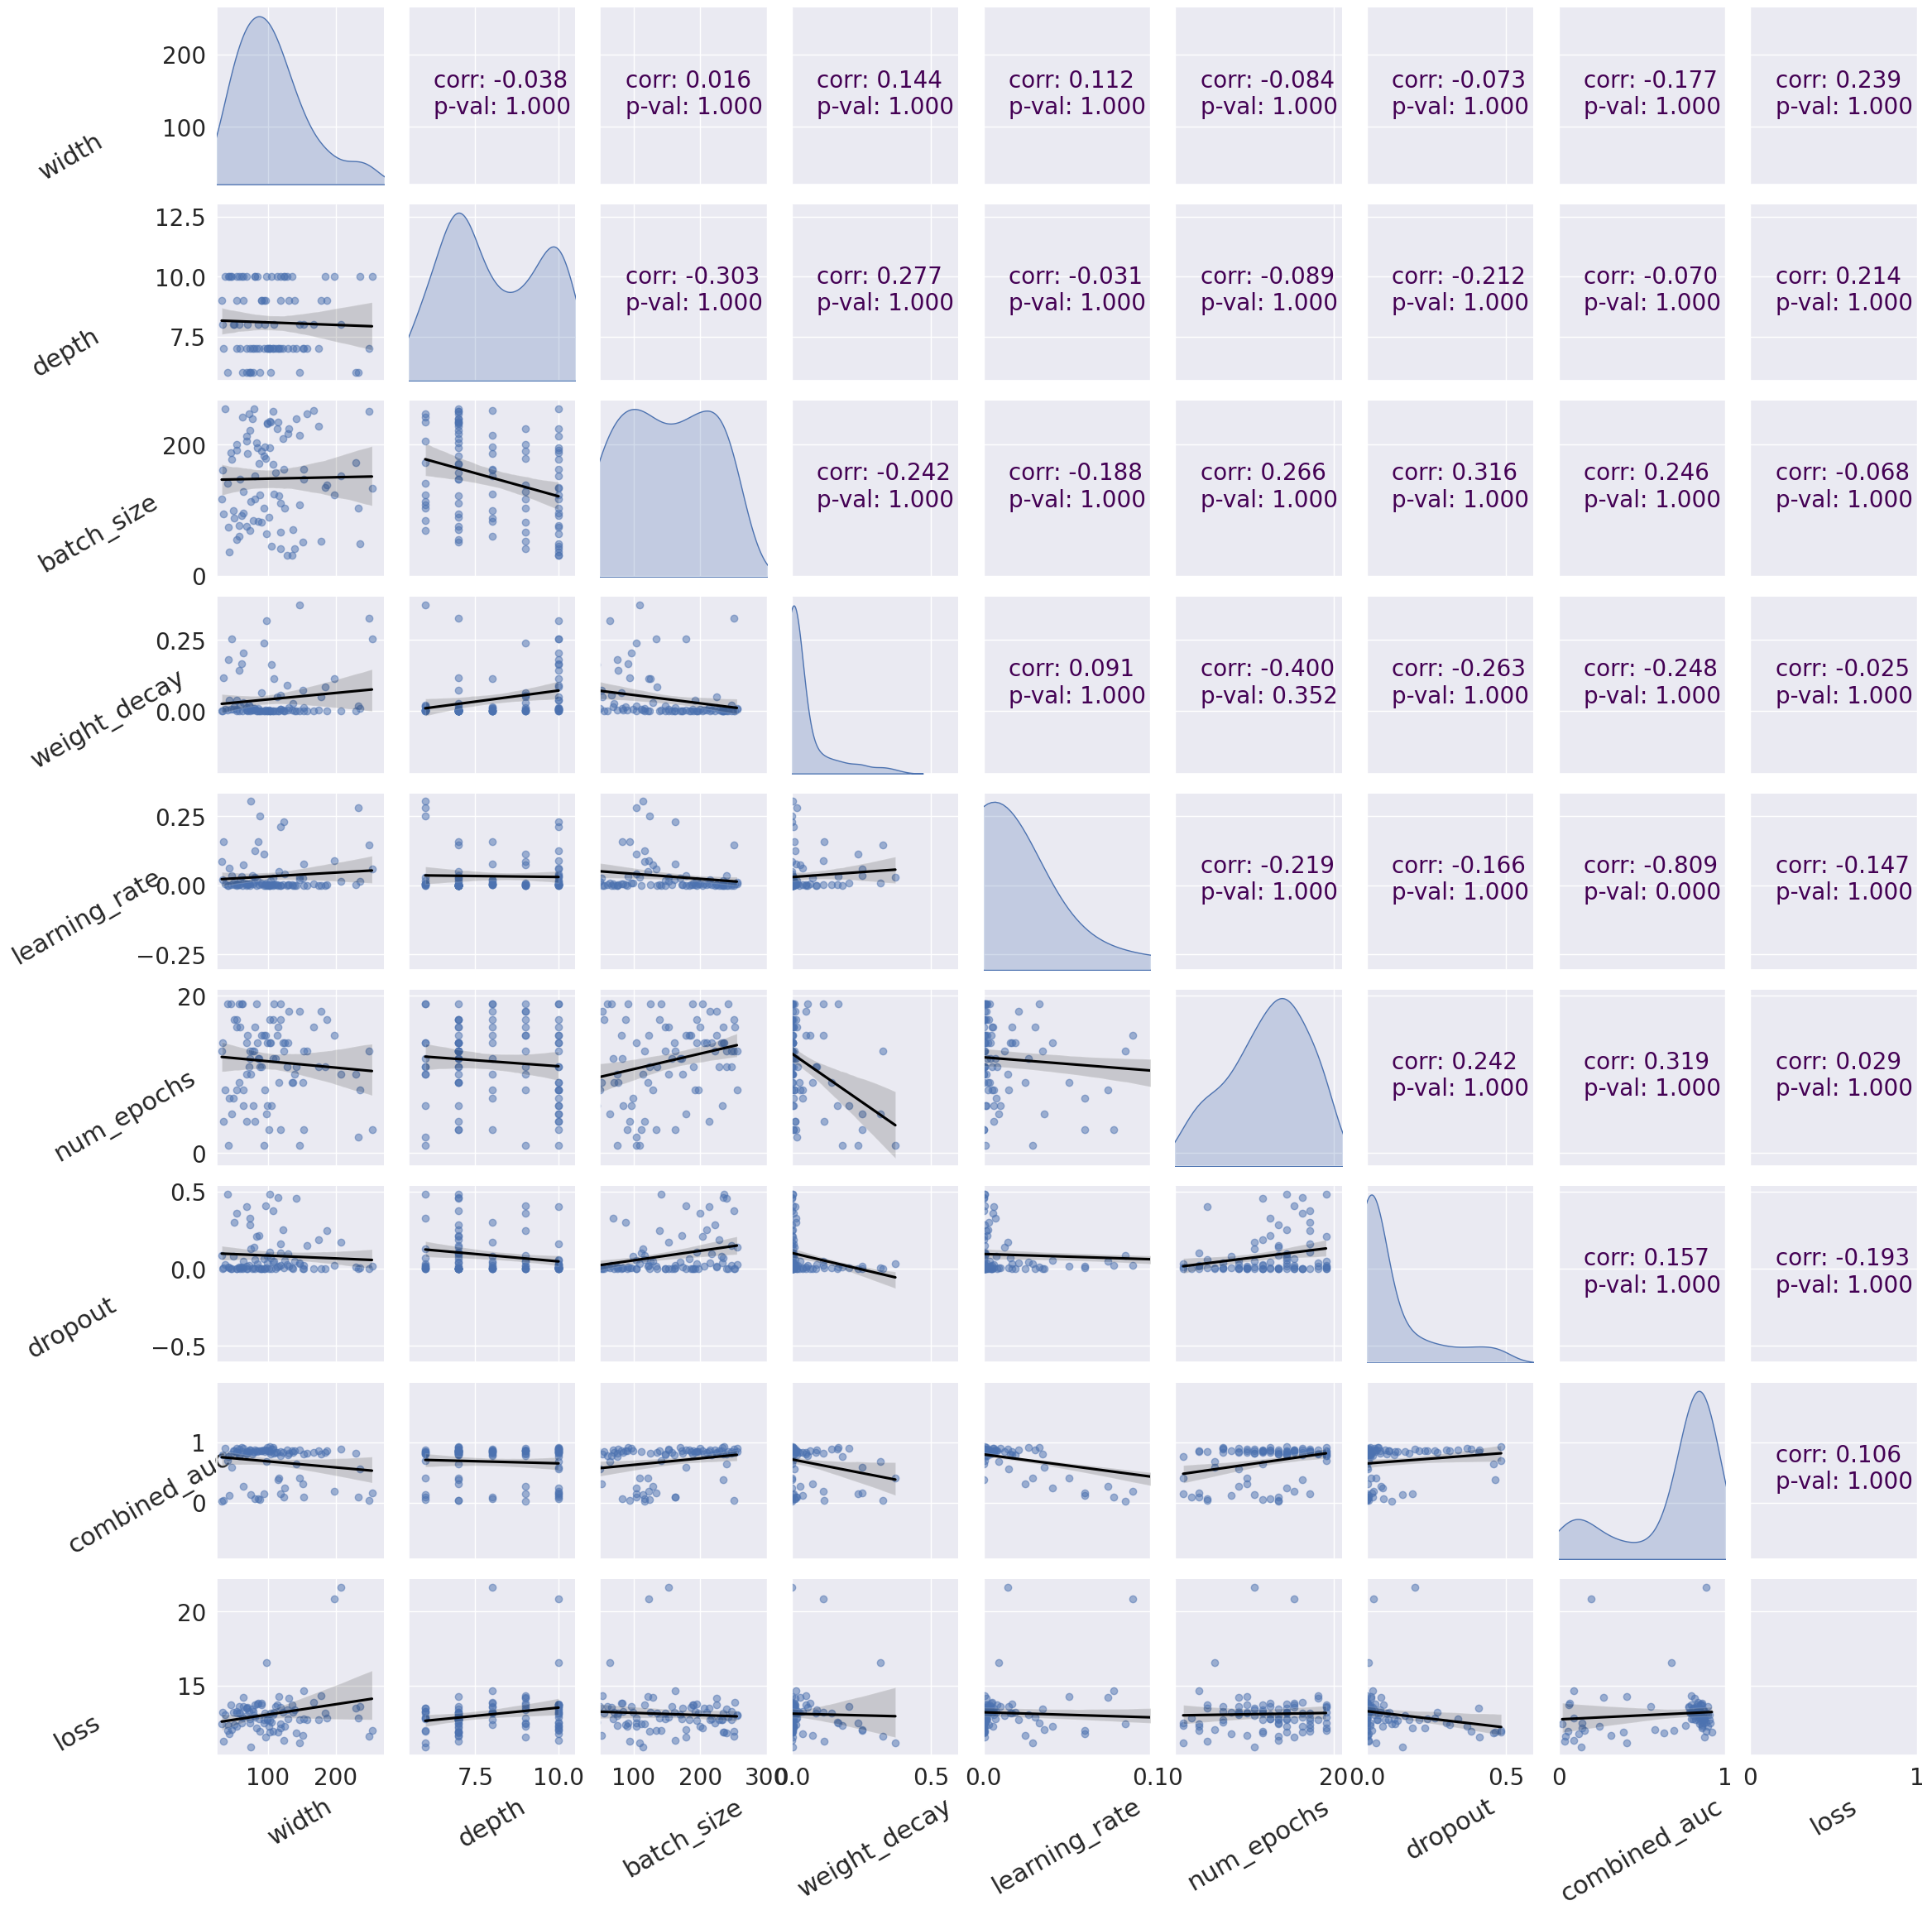

<Figure size 640x480 with 0 Axes>

In [82]:
draw_custom_pairplot(deduped_df)

In [83]:
raise Exception('Stop right there for now')

Exception: Stop right there for now

## Let's Do Hyperparam Optimization!

In [ ]:
seed_everything(0)

def proxy_ranking_lambda(x):
    # Proxy metric is defined as FC (y_raw[:, 1]) + ER (y_raw[:, 2])
    return x[1] + x[2]

top_k_size = 500 if protein_of_interest == "MDM2" else 1000
motif_dectection_func = (
    seq_contains_mdm2_motif
    if protein_of_interest == "MDM2"
    else seq_contains_12ca5_motif
)


X, y_raw, peptides, FEATURE_LIST = data_loading.build_joint_dataset(
    er_datafile=f"{protein_of_interest}_merged_ER.csv",
    volcano_datafile="12ca5-MDM2-R3.csv",
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
)
(X_holdout, X, y_holdout, y_raw, peptides_eval, peptides) = train_test_split(
    X,
    y_raw,
    peptides,
    test_size=0.8,
    shuffle=True,
    random_state=5,
)
print(len(X))


/home/yitongt/ml_phage/src/preprocessing/y_representation.py:73: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = stats.ttest_ind(


25423


In [ ]:
def objective_func(args):
    global SAVE_DF
    seed_everything(0)

    args = {
        "width": int(args['width']),
        "depth": int(args['depth']),
        "batch_size": int(args['batch_size']),
        "weight_decay": round(args["weight_decay"], 5),
        "learning_rate": round(args["learning_rate"], 5),
        "num_epochs": int(args['num_epochs']),
        "dropout": round(args["dropout"], 5),
    }
    print(args)

    def benchmark(result, peptides, ranking_lambda):

        y_pred = result.y_pred_rescaled
        y_true = result.y_test
        loss = np.mean(rnn.multi_channel_mse(y_true, y_pred))
        # Check that the cross folds experiment returns our y_true in the same order as before
        # assert (y_true == y_raw).all()
        mdm2_ordering = [ranking_lambda(pred) for pred in y_pred]
        result = plot_ratio_by_ranking(
            peptides=peptides,
            y_rankings=[(mdm2_ordering, "y_pred", "red")],
            title="",
            hit_rate_func=seq_check,
            peptide_dataset_size=top_k_size,
            plot=False,
            save_file=None,
        )
        return result, loss

    split_datasets, mdm2_results = experiment.Experiment().run_adhoc_experiment(
        X,
        y_raw,
        partial(
            rnn.ThreeChannelRegressionRNN_gelu,
            depth=args["depth"],
            width=args["width"],
            dropout=args["dropout"],
            # activation_func=activation
        ),
        model_save_name=f"grid_search_models_2/{protein_of_interest}/learning_rate({args['learning_rate']})_dropout({args['dropout']})_batch_size({args['batch_size']})_depth({args['depth']})_width({args['width']})_weightdecay({args['weight_decay']}).h5",
        normalize=True,
        batch_size=args["batch_size"],
        optimizer=partial(
            keras.optimizers.Adam,
            learning_rate=args["learning_rate"],
            weight_decay=args["weight_decay"],
        )(),
        num_epochs=args["num_epochs"],
        other_datasets=[peptides]
    )
    peptides_test = split_datasets[5]
    combined_auc, loss = benchmark(mdm2_results, peptides_test, proxy_ranking_lambda)

    series = pd.Series(
        {
            "width": args['width'],
            "depth": args['depth'],
            "batch_size": args['batch_size'],
            "weight_decay": args['weight_decay'],
            "learning_rate": args['learning_rate'],
            "num_epochs": args['num_epochs'],
            "dropout": args['dropout'],
            "combined_auc": combined_auc,
            'loss': loss,
        }
    )
    SAVE_DF = SAVE_DF.append(series, ignore_index=True)
    SAVE_DF.to_csv(f, index=False)
    print("Hey Yitong! Finished! ", len(SAVE_DF))
    return 1 - combined_auc


In [ ]:
from hyperopt import hp

space = {
    "width": hp.uniform("width", 32, 256),
    "depth": hp.choice("depth", [6, 7, 8, 9, 10]),
    "batch_size": hp.uniform("batch_size", 32, 256),
    "weight_decay": hp.loguniform("weight_decay", np.log(0.0001),np.log(0.5)),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.0001),np.log(0.5)),
    "num_epochs": hp.uniform("num_epochs", 1, 20),
    "dropout": hp.loguniform("dropout", np.log(0.0001),np.log(0.5)), 
}


# minimize the objective over the space
from hyperopt import fmin, tpe, rand
best = fmin(objective_func, space, algo=rand.suggest, max_evals=100) # algo=tpe.suggest, max_evals=100)


Epoch 1/20                                             

  0%|          | 0/100 [01:04<?, ?trial/s, best loss=?]


KeyboardInterrupt: 